In [1]:
import gc
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook
from glob import glob

from utils import loadpkl, to_json, scalingPredictions, getBestMultiple

%matplotlib inline

/home/fujiwara/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [29]:
# search a best weight for 2 predictions
def getBestWeights(act, pred_lgbm, pred_xgb):
    search_range = np.arange(0.0, 1.1, 0.1)
    best_weights = []

    # base prediction
    _pred = pd.DataFrame()
    cols_pred=[]
    for i in range(0,12):
        _pred['pred_{}'.format(i)] = 0.5*pred_lgbm['pred_lgbm_plans{}'.format(i)]+ 0.5*pred_xgb['pred_xgb_plans{}'.format(i)]
        cols_pred.append('pred_{}'.format(i))

    # base score
    best_f1=f1_score(act, np.argmax(_pred[cols_pred].values,axis=1),average='weighted')
    
    # get best weights for each classes
    for i in range(0,12):
        f1s = []
        for _w in search_range:
            tmp_pred = _pred[cols_pred]
            tmp_pred['pred_{}'.format(i)] = _w*pred_lgbm['pred_lgbm_plans{}'.format(i)]+ (1.0-_w)*pred_xgb['pred_xgb_plans{}'.format(i)]
                    
            # calc f1 score
            _f1 = f1_score(act, np.argmax(tmp_pred.values,axis=1),average='weighted')
            f1s.append(_f1)
            print('class: {}, w: {}, f1 score: {}'.format(i,_w,_f1))
            if _f1 > best_f1:
                best_f1 = _f1
                best_w = _w

            del tmp_pred

        # save weights & predicted values
        best_weights.append(best_w)
        _pred['pred_{}'.format(i)] = best_w*pred_lgbm['pred_lgbm_plans{}'.format(i)]+ (1.0-best_w)*pred_xgb['pred_xgb_plans{}'.format(i)]
        
        # plot thresholds
        plt.figure()
        plt.plot(search_range, f1s)
        plt.savefig('../imp/multiple{}.png'.format(i))

    return best_weights

class: 0, w: 0.0, f1 score: 0.6654084853428113
class: 0, w: 0.1, f1 score: 0.6658468476422365
class: 0, w: 0.2, f1 score: 0.6663494032604034
class: 0, w: 0.30000000000000004, f1 score: 0.6667824724065792
class: 0, w: 0.4, f1 score: 0.6671671560364848
class: 0, w: 0.5, f1 score: 0.6676876382781729
class: 0, w: 0.6000000000000001, f1 score: 0.668048397267767
class: 0, w: 0.7000000000000001, f1 score: 0.6684460213346094
class: 0, w: 0.8, f1 score: 0.6688252474205871
class: 0, w: 0.9, f1 score: 0.669161613298757
class: 0, w: 1.0, f1 score: 0.6694181389150625
class: 1, w: 0.0, f1 score: 0.6654087394375691
class: 1, w: 0.1, f1 score: 0.6690661584303242
class: 1, w: 0.2, f1 score: 0.6700846261097093
class: 1, w: 0.30000000000000004, f1 score: 0.6702200568267236
class: 1, w: 0.4, f1 score: 0.6699093029726301
class: 1, w: 0.5, f1 score: 0.6694181389150625
class: 1, w: 0.6000000000000001, f1 score: 0.6689968128874274
class: 1, w: 0.7000000000000001, f1 score: 0.6685728524442339
class: 1, w: 0.8,

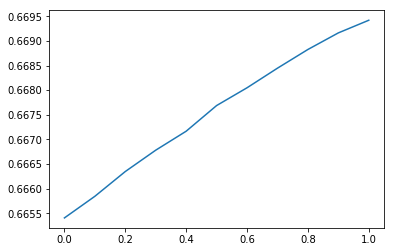

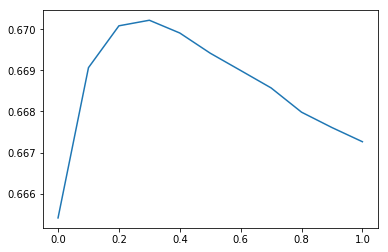

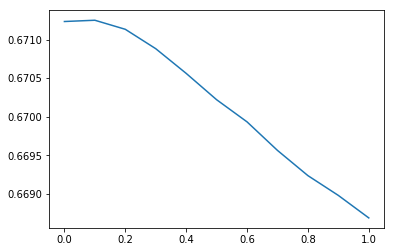

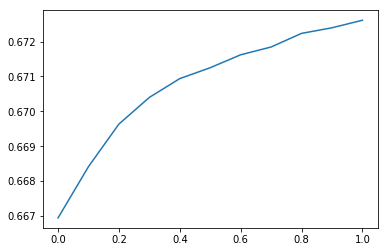

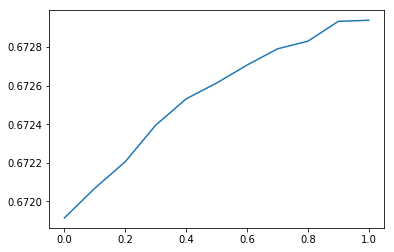

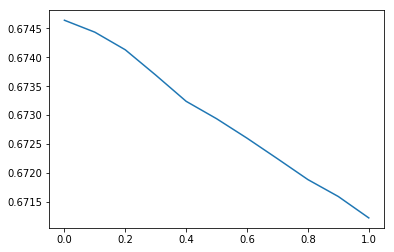

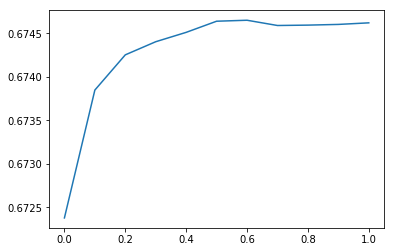

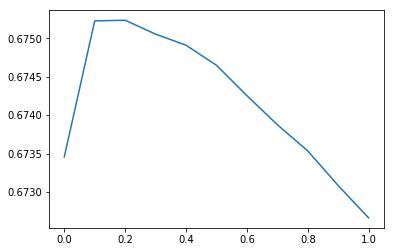

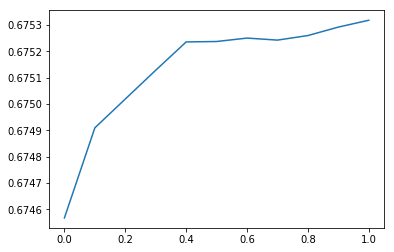

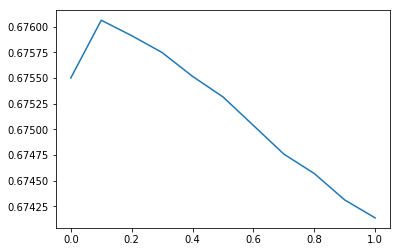

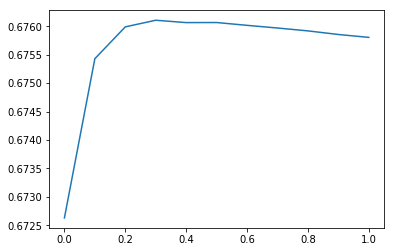

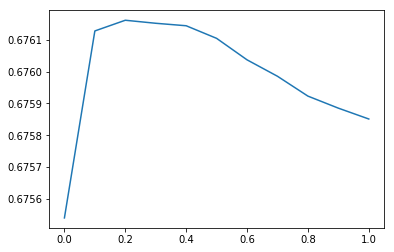

In [30]:
w = 

In [33]:
w

[1.0,
 0.30000000000000004,
 0.1,
 1.0,
 1.0,
 0.0,
 0.6000000000000001,
 0.2,
 1.0,
 0.1,
 0.30000000000000004,
 0.2]

In [3]:
# load predictions
pred_lgbm = loadpkl('../features/lgbm_pred.pkl')
pred_xgb = loadpkl('../features/xgb_pred.pkl')
plans = loadpkl('../features/plans.pkl')

# define columns name list
cols_pred_lgbm = ['pred_lgbm_plans{}'.format(i) for i in range(0,12)]
cols_pred_xgb = ['pred_xgb_plans{}'.format(i) for i in range(0,12)]
cols_transport_mode = ['plan_{}_transport_mode'.format(i) for i in range(0,7)]

# blend predictions
pred = pred_lgbm[['sid','click_mode']]
pred = pd.merge(pred, plans[cols_transport_mode+['sid','plan_num_plans']],on='sid', how='left')

del plans
gc.collect()

# scaling
pred_lgbm[cols_pred_lgbm] = scalingPredictions(pred_lgbm[cols_pred_lgbm])
pred_xgb[cols_pred_xgb] = scalingPredictions(pred_xgb[cols_pred_xgb])

# reset index
pred_lgbm.reset_index(inplace=True,drop=True)
pred_xgb.reset_index(inplace=True,drop=True)

for i in range(1,12):
    tmp = np.zeros(len(pred))
    for c in cols_transport_mode:
        tmp += (pred[c]==i).astype(int)
    pred_lgbm['pred_lgbm_plans{}'.format(i)]=pred_lgbm['pred_lgbm_plans{}'.format(i)]*(tmp>0)
    pred_xgb['pred_xgb_plans{}'.format(i)]=pred_xgb['pred_xgb_plans{}'.format(i)]*(tmp>0)

/media/fujiwara/2THDD/KDD-Cup-2019/src/utils.py:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  pred_df['pred_min'] = pred_df[cols_pred].min(axis=1)


In [21]:
oof_pred_lgbm = pred_lgbm[pred_lgbm.click_mode.notnull()]
oof_pred_xgb = pred_xgb[pred_xgb.click_mode.notnull()]

class: 0, w: 0.0, f1 score: 0.6654084853428113
class: 0, w: 0.1, f1 score: 0.6658468476422365
class: 0, w: 0.2, f1 score: 0.6663494032604034
class: 0, w: 0.30000000000000004, f1 score: 0.6667824724065792
class: 0, w: 0.4, f1 score: 0.6671671560364848
class: 0, w: 0.5, f1 score: 0.6676876382781729
class: 0, w: 0.6000000000000001, f1 score: 0.668048397267767
class: 0, w: 0.7000000000000001, f1 score: 0.6684460213346094
class: 0, w: 0.8, f1 score: 0.6688252474205871
class: 0, w: 0.9, f1 score: 0.669161613298757
class: 0, w: 1.0, f1 score: 0.6694181389150625
class: 1, w: 0.0, f1 score: 0.6654087394375691
class: 1, w: 0.1, f1 score: 0.6690661584303242
class: 1, w: 0.2, f1 score: 0.6700846261097093
class: 1, w: 0.30000000000000004, f1 score: 0.6702200568267236
class: 1, w: 0.4, f1 score: 0.6699093029726301
class: 1, w: 0.5, f1 score: 0.6694181389150625
class: 1, w: 0.6000000000000001, f1 score: 0.6689968128874274
class: 1, w: 0.7000000000000001, f1 score: 0.6685728524442339
class: 1, w: 0.8,

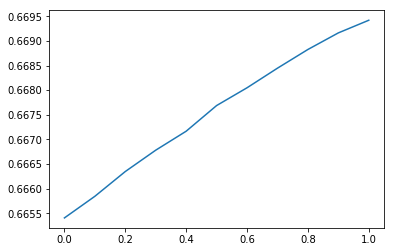

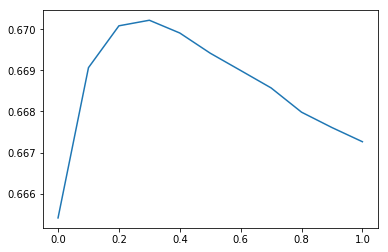

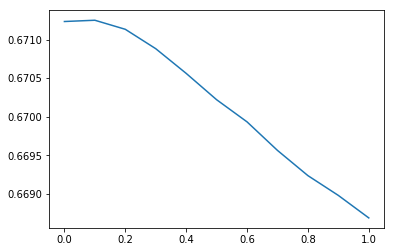

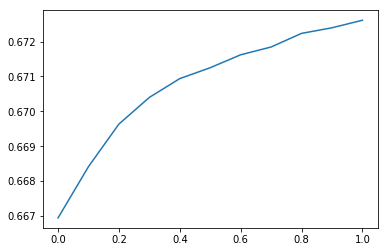

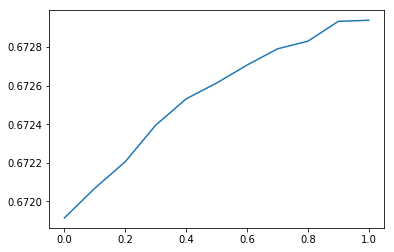

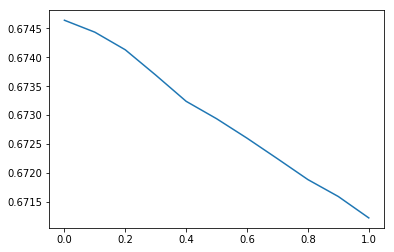

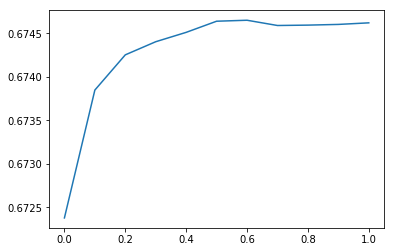

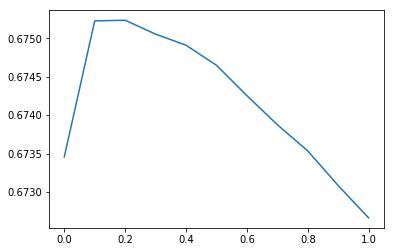

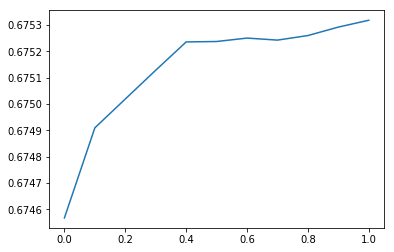

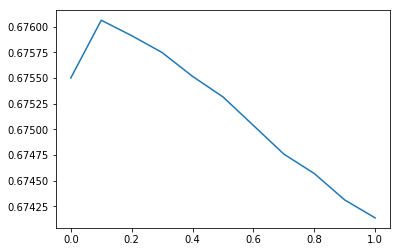

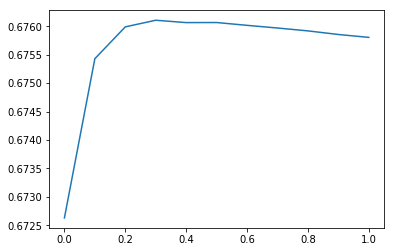

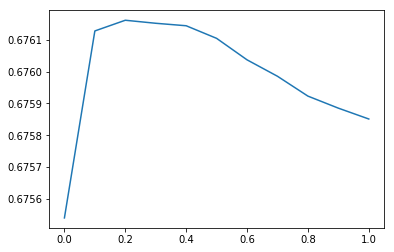

In [34]:
weights = getBestWeights(oof_pred_lgbm.click_mode, oof_pred_lgbm, oof_pred_xgb)

cols_pred =[]
for i , w in enumerate(weights):
    pred['pred_{}'.format(i)] = w*pred_lgbm['pred_lgbm_plans{}'.format(i)]+ (1.0-w)*pred_xgb['pred_xgb_plans{}'.format(i)]
    cols_pred.append('pred_{}'.format(i))

In [35]:
pred['recommend_mode'] = np.argmax(pred[cols_pred].values,axis=1)
pred['recommend_mode'][(pred['plan_num_plans']==1)&(pred['recommend_mode']!=0)] = pred['plan_0_transport_mode'][(pred['plan_num_plans']==1)&(pred['recommend_mode']!=0)]

/home/fujiwara/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [36]:
# split train & test
oof_pred = pred[pred['click_mode'].notnull()]
sub_pred = pred[pred['click_mode'].isnull()]

/media/fujiwara/2THDD/KDD-Cup-2019/src/utils.py:225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  tmp_pred[col] *= _m


multiple: 1.0, f1 score: 0.6761610070753011
multiple: 1.01, f1 score: 0.6761776941394898
multiple: 1.02, f1 score: 0.6762262186953483
multiple: 1.03, f1 score: 0.6762555816587029
multiple: 1.04, f1 score: 0.6762722827588392
multiple: 1.05, f1 score: 0.6762886392187021
multiple: 1.06, f1 score: 0.6762933252258133
multiple: 1.07, f1 score: 0.6763075376801124
multiple: 1.08, f1 score: 0.6763355446188342
multiple: 1.09, f1 score: 0.676343851030594
multiple: 1.1, f1 score: 0.6763754638707772
multiple: 1.11, f1 score: 0.6764011839261851
multiple: 1.12, f1 score: 0.6764291590737102
multiple: 1.1300000000000001, f1 score: 0.6764402463253932
multiple: 1.1400000000000001, f1 score: 0.6764953414066712
multiple: 1.1500000000000001, f1 score: 0.6765456706201856
multiple: 1.1600000000000001, f1 score: 0.6765990237084499
multiple: 1.1700000000000002, f1 score: 0.6766233549905885
multiple: 1.1800000000000002, f1 score: 0.6766149324953888
multiple: 1.1900000000000002, f1 score: 0.6766532092658631
multi

/home/fujiwara/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


multiple: 1.0, f1 score: 0.6770481360578969
multiple: 1.01, f1 score: 0.6771150580462516
multiple: 1.02, f1 score: 0.6772138732140063
multiple: 1.03, f1 score: 0.6772727489244307
multiple: 1.04, f1 score: 0.6773168083979205
multiple: 1.05, f1 score: 0.6774263995281005
multiple: 1.06, f1 score: 0.6774965112081183
multiple: 1.07, f1 score: 0.6776072972461638
multiple: 1.08, f1 score: 0.6777450911384607
multiple: 1.09, f1 score: 0.6778012389925184
multiple: 1.1, f1 score: 0.6778854265881554
multiple: 1.11, f1 score: 0.6779656463630728
multiple: 1.12, f1 score: 0.6780522668208612
multiple: 1.1300000000000001, f1 score: 0.6781143873666758
multiple: 1.1400000000000001, f1 score: 0.678207795489261
multiple: 1.1500000000000001, f1 score: 0.6783460104772985
multiple: 1.1600000000000001, f1 score: 0.6784005541632013
multiple: 1.1700000000000002, f1 score: 0.6784543238962442
multiple: 1.1800000000000002, f1 score: 0.6785552539454646
multiple: 1.1900000000000002, f1 score: 0.6786380132683102
multi

/home/fujiwara/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


multiple: 1.0, f1 score: 0.6791334089467147
multiple: 1.01, f1 score: 0.6792147909429038
multiple: 1.02, f1 score: 0.679231335257056
multiple: 1.03, f1 score: 0.6792494873761544
multiple: 1.04, f1 score: 0.6792390411593119
multiple: 1.05, f1 score: 0.6793148562147475
multiple: 1.06, f1 score: 0.6793248579204451
multiple: 1.07, f1 score: 0.6793981828087888
multiple: 1.08, f1 score: 0.6794518737701926
multiple: 1.09, f1 score: 0.6794820921182361
multiple: 1.1, f1 score: 0.6794942554843766
multiple: 1.11, f1 score: 0.6794939855282504
multiple: 1.12, f1 score: 0.6794870043124878
multiple: 1.1300000000000001, f1 score: 0.6795047829327071
multiple: 1.1400000000000001, f1 score: 0.679486885549352
multiple: 1.1500000000000001, f1 score: 0.6794965892426452
multiple: 1.1600000000000001, f1 score: 0.6795165643633834
multiple: 1.1700000000000002, f1 score: 0.6795180125684216
multiple: 1.1800000000000002, f1 score: 0.679490483112506
multiple: 1.1900000000000002, f1 score: 0.679476965524999
multiple

/home/fujiwara/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


multiple: 1.0, f1 score: 0.6795180125684216
multiple: 1.01, f1 score: 0.6795415923590313
multiple: 1.02, f1 score: 0.6795584391826458
multiple: 1.03, f1 score: 0.6795480928936194
multiple: 1.04, f1 score: 0.6795813131020177
multiple: 1.05, f1 score: 0.6795834525577252
multiple: 1.06, f1 score: 0.6795971043014412
multiple: 1.07, f1 score: 0.679583340060549
multiple: 1.08, f1 score: 0.6795737401438191
multiple: 1.09, f1 score: 0.6795691349654449
multiple: 1.1, f1 score: 0.679541316429755
multiple: 1.11, f1 score: 0.67954639391694
multiple: 1.12, f1 score: 0.6795276507272884
multiple: 1.1300000000000001, f1 score: 0.6795296209446832
multiple: 1.1400000000000001, f1 score: 0.6795249814905036
multiple: 1.1500000000000001, f1 score: 0.6795423441398929
multiple: 1.1600000000000001, f1 score: 0.6795508907233482
multiple: 1.1700000000000002, f1 score: 0.6795212667325569
multiple: 1.1800000000000002, f1 score: 0.679525394304929
multiple: 1.1900000000000002, f1 score: 0.6795226261267268
multiple:

/home/fujiwara/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


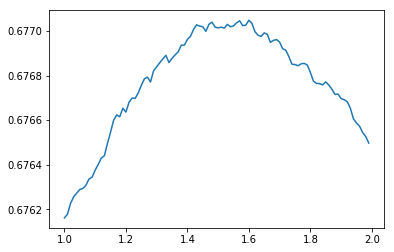

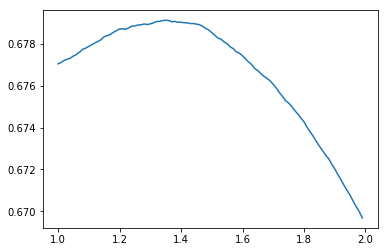

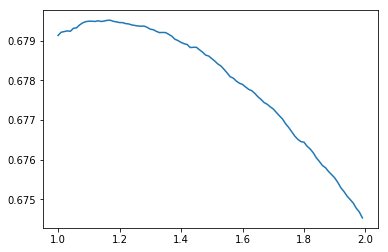

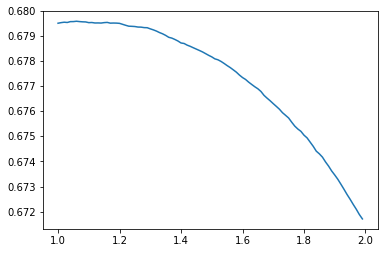

In [37]:
# get out of fold values
oof_pred = pred[pred['click_mode'].notnull()]

# get best multiples
m4 = getBestMultiple(oof_pred,'pred_4',cols_pred,'../imp/multiple4.png')
pred['pred_4'] *= m4
oof_pred['pred_4'] *= m4

m0 = getBestMultiple(oof_pred,'pred_0',cols_pred,'../imp/multiple0.png')
pred['pred_0'] *= m0
oof_pred['pred_0'] *= m0

m3 = getBestMultiple(oof_pred,'pred_3',cols_pred,'../imp/multiple3.png')
pred['pred_3'] *= m3
oof_pred['pred_3'] *= m3

m6 = getBestMultiple(oof_pred,'pred_6',cols_pred,'../imp/multiple6.png')
pred['pred_6'] *= m6
oof_pred['pred_6'] *= m6

In [38]:
# get recommend mode
pred['recommend_mode'] = np.argmax(pred[cols_pred].values,axis=1)

# if number of plans = 1 and recommend mode != 0, set recommend mode as plan 0 mode.
pred['recommend_mode'][(pred['plan_num_plans']==1)&(pred['recommend_mode']!=0)] = pred['plan_0_transport_mode'][(pred['plan_num_plans']==1)&(pred['recommend_mode']!=0)]

# split train & test
sub_pred = pred[pred['click_mode'].isnull()]
oof_pred = pred[pred['click_mode'].notnull()]

# out of fold score
f1_score(oof_pred['click_mode'], oof_pred['recommend_mode'],average='weighted')

/home/fujiwara/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


0.6795971043014412

In [39]:
w_click = oof_pred.click_mode.astype(int).value_counts(normalize=True).to_dict()
w_recommend = oof_pred.recommend_mode.value_counts(normalize=True).to_dict()

In [40]:
for i, c in enumerate(cols_pred):
    print(w_click[i]/w_recommend[i])

2.1846510280915146
0.9163346094746986
0.9208117170054443
1.8463037936722149
2.835357624831309
0.9807080596521667
1.4606008372322088
0.8822222222222221
0.7976804123711341
0.8745078387858831
0.7190761499806726
0.8829756380510441
